# QUBIC 1D
# Exploring the "Gaussian Peak Approximation"
## JCH - Feb 2025
In this notebook we investigate the issue of TOD realism mentioned in `QUBIC-1D.ipynb`.

## Mandatory Imports

In [15]:
#%matplotlib ipympl
%matplotlib widget
# %matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from importlib import reload   

from qubic.lib import Q1d as q1d 
from qubic.lib.Calibration.Qfiber import profile

plt.rc('image', cmap='jet')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook we will explore the Gaussian peak approximation: the QUBIC synthesized beam has a complex shape, not only exhibiting multiple peaks, but also ripples in between the peaks, due to the combination of all the interferometer baselines formed by the horn array. However, this is very complex to model when eprforming mapmaking. As a consequence, our mapmaking algorithm is based on an assumption, known as the "Gaussian Peak Apprximation" that approximates our synthesized beam by a series of Gaussian, one for each peak of the synthesized. This is efficient in the sense that the QUBIC mapmaking problem therefore reduces to slightly modifying the pointing matrix H, which in an imager contins only a sngle 1 (and the rest 0) per row, correspomding to the sky pixel where the detector points for this time sample. For QUBIC there is not just a 1 and the rest 0 but a few pixels with amplitudes of the peaks of the synthesized beam that point in this direction, and the rest is 0.

We want to assess wether this assumption has significant effects on the reconstructed sky. Let's remark that we will explore this here with a 1D model, for which the ratio between the area under the gaussian peaks and the ripples is likely much larger than for the real 2D case. This is to be checked however. If true, this means that the 2D case will actually be less impacted that what we will see here.

Let's first have a look at the real synthesized beam:

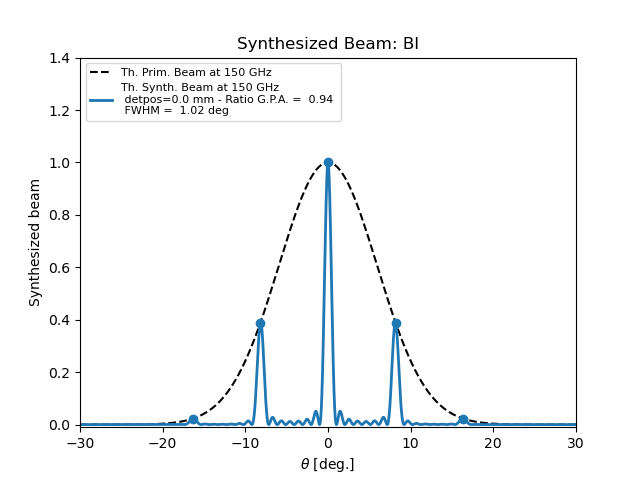

In [16]:
params = {'TOD_method':'exact'}
inst_BI = q1d.Q1D(instrument_type='BI', params=params, plot_sb=True)

And now the Gaussian Peak Approximation:

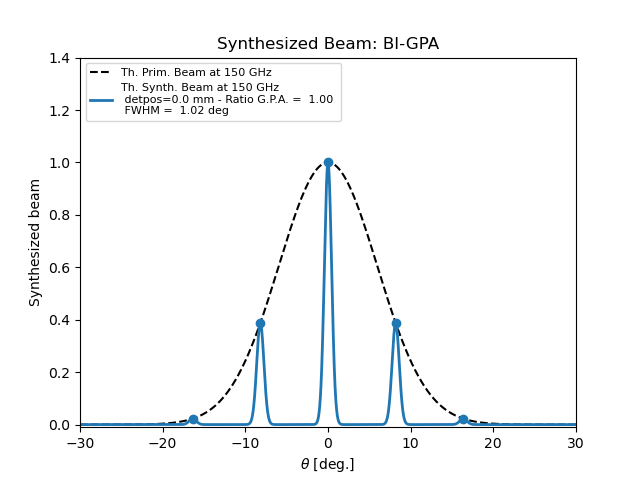

In [17]:
inst_BI_GPA = q1d.Q1D(instrument_type='BI-GPA', params=params, plot_sb=True)

The idea is therefore to build TODs with the `exact` method (see notebook Q1D-TOD-Realism.ipynb) in order to mimick as much as possible a sky observation (note that for now this analysis is monochromatic, so not so realistic...) and then reconstruct using the Gaussian Peak Approximation: this is what the `BI` instrument will be doing (we always reconstruct under the GPA). In order to compare with a case where the ripples are not present, we will use the `BI-GPA` as a point of comparison.

We have to be extra-careful here as we have seen that constructing the TODs with the `exact` method leads to biases in the reconstruction due to the fact that our mapmaking approximates the acquisition by $H.\vec{s}$ ($H$ is the acquisition operator and $\vec{s}$ the sky) where $H$ is pixellized and therefore not equivalent to the perfect convolution by the synthesized beam made with the `exact` methd. We are therefore exploring biases beyond this one, that would be due to the Gaussian Peak Approximation. We will therefore need to study both biases together. As a consequence, the (`BI`, `exact`) case will have to be compared to a combination of the ('`BI-GPA`, `exact`) and the (`BI-GPA`, `approx`) cases in order to disentangle the biases arising from the GPA and those arising from the `H` approximation.


Realization 0 over 30


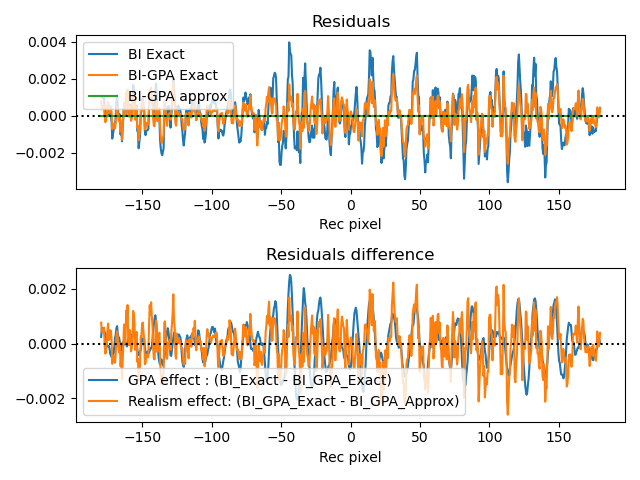

Realization 1 over 30
Realization 2 over 30
Realization 3 over 30
Realization 4 over 30
Realization 5 over 30
Realization 6 over 30
Realization 7 over 30
Realization 8 over 30
Realization 9 over 30
Realization 10 over 30
Realization 11 over 30
Realization 12 over 30
Realization 13 over 30
Realization 14 over 30
Realization 15 over 30
Realization 16 over 30
Realization 17 over 30
Realization 18 over 30
Realization 19 over 30
Realization 20 over 30
Realization 21 over 30
Realization 22 over 30
Realization 23 over 30
Realization 24 over 30
Realization 25 over 30
Realization 26 over 30
Realization 27 over 30
Realization 28 over 30
Realization 29 over 30


In [5]:
npix = 360*2
nptg = 50000
params_exact = {'plot_sb': False, 'plot_reconstructed': False, 'TOD_method': 'exact', 'npix':npix, 'npointings':nptg}
params_approx = {'plot_sb': False, 'plot_reconstructed': False, 'TOD_method': 'approx', 'npix':npix, 'npointings':nptg}

nbmc = 30
doplot = True
all_truth = np.zeros((nbmc, npix))
all_results_BI_exact = np.zeros((nbmc, npix))
all_results_BI_GPA_exact = np.zeros((nbmc, npix))
all_results_BI_GPA_approx = np.zeros((nbmc, npix))
all_residuals_BI_exact = np.zeros((nbmc, npix))
all_residuals_BI_GPA_exact = np.zeros((nbmc, npix))
all_residuals_BI_GPA_approx = np.zeros((nbmc, npix))
all_GPA_effect = np.zeros((nbmc, npix))
all_Realism_effect = np.zeros((nbmc, npix))

for i in range(nbmc):
    print('Realization {} over {}'.format(i,nbmc))

    ### Make sure they all have the same seeds for a given iteration
    params_exact['sky_seed'] = np.random.randint(1e6)
    params_exact['pointing_seed'] = np.random.randint(1e6)
    params_exact['noise_seed'] = np.random.randint(1e6)
    params_approx['sky_seed'] = params_exact['sky_seed']
    params_approx['pointing_seed'] = params_exact['pointing_seed']
    params_approx['noise_seed'] = params_exact['noise_seed']

    # instantiate instruments
    inst_BI_exact = q1d.Q1D(instrument_type='BI', params = params_exact)
    inst_BIGPA_exact = q1d.Q1D(instrument_type='BI-GPA', params = params_exact)
    inst_BIGPA_approx = q1d.Q1D(instrument_type='BI-GPA', params = params_approx)

    # perform simulation
    result_BI_exact = inst_BI_exact.simulate_and_reconstruct()
    result_BIGPA_exact = inst_BIGPA_exact.simulate_and_reconstruct()
    result_BIGPA_approx = inst_BIGPA_approx.simulate_and_reconstruct()
    
    # get residuals
    residuals_BI_exact = result_BI_exact['solution_all'] - inst_BI_exact.convolved_sky_pix
    residuals_BIGPA_exact = result_BIGPA_exact['solution_all'] - inst_BIGPA_exact.convolved_sky_pix
    residuals_BIGPA_approx = result_BIGPA_approx['solution_all'] - inst_BIGPA_approx.convolved_sky_pix

    # GPA and Realism effects
    GPA_effect = residuals_BI_exact - residuals_BIGPA_exact
    Realism_effect = residuals_BIGPA_exact - residuals_BIGPA_approx

    if doplot:
        if i==0:
            plt.figure()
            plt.subplot(2,1,1)
            plt.plot(inst_BI_exact.rec_pix_centers, residuals_BI_exact, label='BI Exact')
            plt.plot(inst_BIGPA_exact.rec_pix_centers, residuals_BIGPA_exact, label='BI-GPA Exact')
            plt.plot(inst_BIGPA_approx.rec_pix_centers, residuals_BIGPA_approx, label='BI-GPA approx')
            plt.axhline(y=0, color='k', ls=':')
            plt.xlabel("Rec pixel")
            plt.title("Residuals")
            plt.legend()

            plt.subplot(2,1,2)
            plt.plot(inst_BI_exact.rec_pix_centers, GPA_effect, label='GPA effect : (BI_Exact - BI_GPA_Exact)')
            plt.plot(inst_BIGPA_exact.rec_pix_centers, Realism_effect, label='Realism effect: (BI_GPA_Exact - BI_GPA_Approx)')
            plt.axhline(y=0, color='k', ls=':')
            plt.xlabel("Rec pixel")
            plt.title("Residuals difference")
            plt.legend()
            plt.tight_layout()
            plt.show()
            

    all_truth[i,:] = inst_BI_exact.convolved_sky_pix
    all_results_BI_exact[i,:] = result_BI_exact['solution_all']
    all_results_BI_GPA_exact[i,:] = result_BIGPA_exact['solution_all']
    all_results_BI_GPA_approx[i,:] = result_BIGPA_approx['solution_all']
    all_residuals_BI_exact[i,:] = result_BI_exact['solution_all'] - inst_BI_exact.convolved_sky_pix
    all_residuals_BI_GPA_exact[i,:] = result_BIGPA_exact['solution_all'] - inst_BIGPA_exact.convolved_sky_pix
    all_residuals_BI_GPA_approx[i,:] = result_BIGPA_approx['solution_all'] - inst_BIGPA_approx.convolved_sky_pix
    all_GPA_effect[i,:] = GPA_effect
    all_Realism_effect[i,:] = Realism_effect




In [6]:
# ii = 0
# plt.figure()
# plt.subplot(3,1,1)
# plt.title('Reconstruction: Realization #{}'.format(ii))
# plt.plot(inst_BI.rec_pix_centers , all_truth[ii,:], label='Truth')
# plt.plot(inst_BI.rec_pix_centers , all_results_BI_exact[ii,:], 'o', alpha=0.3, label='BI Exact')
# plt.plot(inst_BI.rec_pix_centers , all_results_BI_GPA_exact[ii,:], '.', alpha=0.3, label='BI-GPA Exact')
# plt.plot(inst_BI.rec_pix_centers , all_results_BI_GPA_approx[ii,:], '+', alpha=0.3, label='BI-GPA approx')
# plt.axhline(y=0, color='k', ls=':')
# plt.xlabel("Rec pixel")
# plt.legend()


# plt.subplot(3,1,2)
# plt.title('Residuals: Realization #{}'.format(ii))
# plt.plot(inst_BI.rec_pix_centers , all_residuals_BI_exact[ii,:], label='BI Exact')
# plt.plot(inst_BI.rec_pix_centers , all_residuals_BI_GPA_exact[ii,:], label='BI-GPA Exact')
# plt.plot(inst_BI.rec_pix_centers , all_residuals_BI_GPA_approx[ii,:], label='BI-GPA approx')
# plt.axhline(y=0, color='k', ls=':')
# plt.xlabel("Rec pixel")
# plt.legend()

# plt.subplot(3,1,3)
# plt.title('Residuals: Realization #{}'.format(ii))
# plt.plot(inst_BI.rec_pix_centers , all_GPA_effect[ii,:], label='GPA Effect')
# plt.plot(inst_BI.rec_pix_centers , all_Realism_effect[ii,:], label='Realism Effect')
# plt.axhline(y=0, color='k', ls=':')
# plt.xlabel("Rec pixel")
# plt.legend()

# plt.tight_layout()
# plt.show()




In [18]:
### Fourier analysis

all_ps_sky = np.zeros((nbmc, npix))
all_ps_BI_exact = np.zeros((nbmc, npix))
all_ps_BI_GPA_exact = np.zeros((nbmc, npix))
all_ps_BI_GPA_approx = np.zeros((nbmc, npix))
all_psres_BI_exact = np.zeros((nbmc, npix))
all_psres_BI_GPA_exact = np.zeros((nbmc, npix))
all_psres_BI_GPA_approx = np.zeros((nbmc, npix))
all_ps_GPA_effect = np.zeros((nbmc, npix))
all_ps_Realism_effect = np.zeros((nbmc, npix))

for i in range(nbmc):
    freq_pix = np.abs(np.fft.fftfreq(len(inst_BI_exact.rec_pix_centers), 
                                    d=inst_BI_exact.rec_pix_centers[1]-inst_BI_exact.rec_pix_centers[0]))
    ### Input sky
    all_ps_sky[i,:] = np.abs(np.fft.fft(all_truth[i,:]))**2 / len(inst_BI_exact.rec_pix_centers)**2
    ### Reconstructed
    all_ps_BI_exact[i,:] = np.abs(np.fft.fft(all_results_BI_exact[i,:]))**2 / npix**2
    all_ps_BI_GPA_exact[i,:] = np.abs(np.fft.fft(all_results_BI_GPA_exact[i,:]))**2 / npix**2
    all_ps_BI_GPA_approx[i,:] = np.abs(np.fft.fft(all_results_BI_GPA_approx[i,:]))**2 / npix**2
    # ### Residuals
    all_psres_BI_exact[i,:] = np.abs(np.fft.fft(all_residuals_BI_exact[i,:]))**2 / npix**2
    all_psres_BI_GPA_exact[i,:] = np.abs(np.fft.fft(all_residuals_BI_GPA_exact[i,:]))**2 / npix**2
    all_psres_BI_GPA_approx[i,:] = np.abs(np.fft.fft(all_residuals_BI_GPA_approx[i,:]))**2 / npix**2
    # ### GPA and Realism Effects
    all_ps_GPA_effect[i,:] = np.abs(np.fft.fft(all_GPA_effect[i,:]))**2 / npix**2
    all_ps_Realism_effect[i,:] = np.abs(np.fft.fft(all_Realism_effect[i,:]))**2 / npix**2


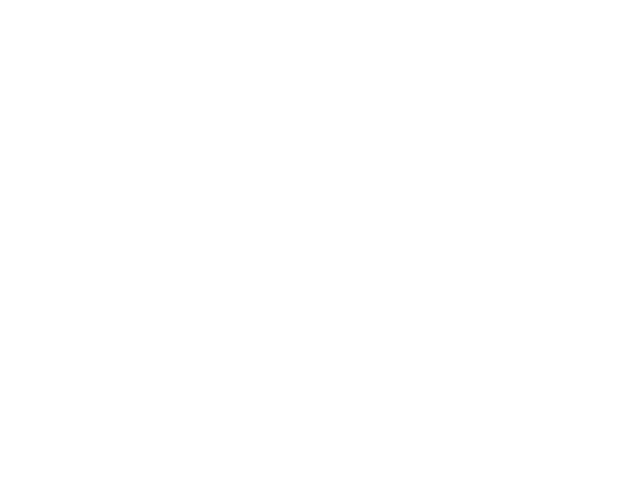

In [19]:
known_freqs = []
known_freqs.append({'label':'FWHM: {0:5.3g} deg'.format(inst_BI_exact.fwhmpeak[0]), 'freq': 1./(inst_BI_exact.fwhmpeak[0])/2, 'color':'g', 'ls':'-', 'lw': 3, 'nbharm': 1})
known_freqs.append({'label':'Rec Pixel', 'freq': 1./(inst_BI_exact.rec_pix_centers[1]-inst_BI_exact.rec_pix_centers[0])/2, 'color':'r', 'ls':'-', 'lw': 3, 'nbharm': 1 })
known_freqs.append({'label':'Interpeak distance', 'freq': 1./(inst_BI_exact.thetapeaks[0][1]-inst_BI_exact.thetapeaks[0][0])/2, 'color':'b', 'ls':'-', 'lw': 1, 'nbharm': 16 })

ps_sky = np.mean(all_ps_sky, axis=0)
ps_BI_exact = np.mean(all_ps_BI_exact, axis=0)
ps_BI_GPA_exact = np.mean(all_ps_BI_GPA_exact, axis=0)
ps_BI_GPA_approx = np.mean(all_ps_BI_GPA_approx, axis=0)
psres_BI_exact = np.mean(all_psres_BI_exact, axis=0)
psres_BI_GPA_exact = np.mean(all_psres_BI_GPA_exact, axis=0)
psres_BI_GPA_approx = np.mean(all_psres_BI_GPA_approx, axis=0)
ps_GPA_effect = np.mean(all_ps_GPA_effect, axis=0)
ps_Realism_effect = np.mean(all_ps_Realism_effect, axis=0)

aa=0.3

plt.figure()
plt.show()
plt.plot(freq_pix, ps_sky, color='k', label='True Sky')
plt.plot(freq_pix, ps_BI_exact, label='BI Exact')
plt.plot(freq_pix, ps_BI_GPA_exact , label='BI-GPA Exact')
plt.plot(freq_pix, ps_BI_GPA_approx, label='BI-GPA Approx')
plt.plot(freq_pix, psres_BI_exact, label='Residuals BI Exact')
plt.plot(freq_pix, psres_BI_GPA_exact, label='Residuals BI-GPA Exact')
plt.plot(freq_pix, psres_BI_GPA_approx, label='Residuals BI-GPA Approx')
plt.plot(freq_pix, ps_GPA_effect, label='GPA Effect')
plt.plot(freq_pix, ps_Realism_effect, label='Realism Effect')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=aa, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=aa)

plt.xlabel('Freq')
plt.xlabel('SED')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()




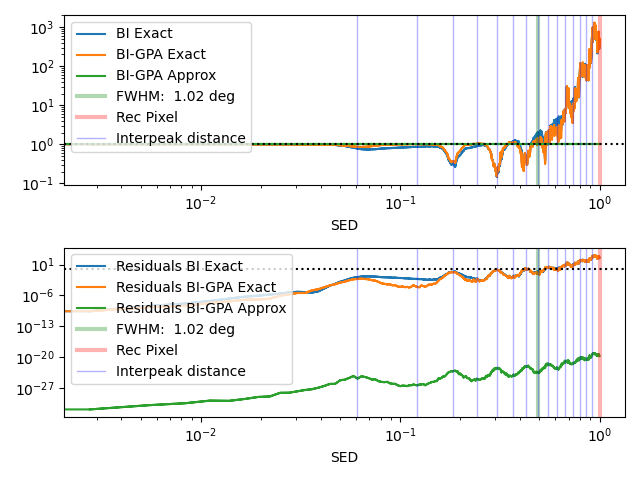

In [20]:

plt.figure()
plt.subplot(2,1,1)
#plt.title('Transfert function (out / in)')
plt.plot(freq_pix, ps_BI_exact / ps_sky, label='BI Exact')
plt.plot(freq_pix, ps_BI_GPA_exact / ps_sky , label='BI-GPA Exact')
plt.plot(freq_pix, ps_BI_GPA_approx / ps_sky, label='BI-GPA Approx')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=aa, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=aa)
plt.axhline(y=1, color='k', ls=':')
plt.xlabel('Freq')
plt.xlabel('SED')
plt.xscale('log')
plt.yscale('log')
plt.legend()


plt.subplot(2,1,2)
plt.plot(freq_pix, psres_BI_exact / ps_sky, label='Residuals BI Exact')
plt.plot(freq_pix, psres_BI_GPA_exact / ps_sky, label='Residuals BI-GPA Exact')
plt.plot(freq_pix, psres_BI_GPA_approx / ps_sky, label='Residuals BI-GPA Approx')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=aa, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=aa)
plt.axhline(y=1, color='k', ls=':')
plt.xlabel('Freq')
plt.xlabel('SED')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.tight_layout()

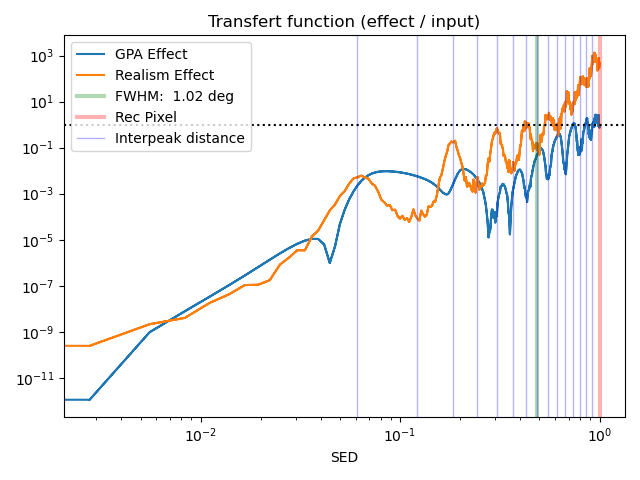

In [21]:
plt.figure()
plt.title('Transfert function (effect / input)')
plt.plot(freq_pix, ps_GPA_effect / ps_sky, label='GPA Effect')
plt.plot(freq_pix, ps_Realism_effect / ps_sky, label='Realism Effect')
for fff in known_freqs:
    p=plt.axvline(x = fff['freq'], ls=fff['ls'], lw=fff['lw'], alpha=aa, label=fff['label'], color=fff['color'])
    for i in range(2,fff['nbharm']):
        plt.axvline(x = i * fff['freq'], ls=fff['ls'], lw=fff['lw'], color=fff['color'], alpha=aa)
plt.axhline(y=1, color='k', ls=':')
plt.xlabel('Freq')
plt.xlabel('SED')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()

